In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import urllib.parse

from dotenv import load_dotenv

sns.set(font_scale=1.2)
%matplotlib inline

In [2]:
load_dotenv('.env')

True

In [3]:
activity_id = 5221335421

In [4]:
token = os.getenv('TOKEN')
headers = {'Authorization': f'Bearer {token}'}
api_url = f'https://www.strava.com/api/v3/activities/{activity_id}/streams?'

In [5]:
params = {"keys": "cadence", "key_by_type": True}
values_url = urllib.parse.urlencode(params)
cad_dist = requests.get(api_url + values_url, headers=headers).json()
cadence = cad_dist['cadence']['data']
hr = requests.get(api_url + 'keys=heartrate&key_by_type=true', headers=headers).json()['heartrate']['data']
pace = requests.get(api_url + 'keys=velocity_smooth&key_by_type=true',headers=headers).json()['velocity_smooth']['data']
grade = requests.get(api_url + 'keys=grade_smooth&key_by_type=true', headers=headers).json()['grade_smooth']['data']
print(values_url)

keys=cadence&key_by_type=True


In [8]:
dist = cad_dist['distance']['data']

In [9]:
df = pd.DataFrame({'speed': pace, 'hr': hr, 'grade': grade, 'cadence': cadence, 'distance': dist})

In [10]:
df = df[df['cadence'] > 0]
df = df[df['speed'] > 1]
df.reset_index()
df['cadence'] = df['cadence'] * 2

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199 entries, 2 to 1200
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   speed     1199 non-null   float64
 1   hr        1199 non-null   int64  
 2   grade     1199 non-null   float64
 3   cadence   1199 non-null   int64  
 4   distance  1199 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 56.2 KB


(array([ 3.,  4.,  4.,  8., 10., 27., 50., 51., 92., 95.,  0., 92., 67.,
        59., 67., 70., 55., 62., 63., 56., 58.,  0., 43., 28., 13., 24.,
        23., 37., 17., 12.,  7.,  2.]),
 array([140.     , 140.90625, 141.8125 , 142.71875, 143.625  , 144.53125,
        145.4375 , 146.34375, 147.25   , 148.15625, 149.0625 , 149.96875,
        150.875  , 151.78125, 152.6875 , 153.59375, 154.5    , 155.40625,
        156.3125 , 157.21875, 158.125  , 159.03125, 159.9375 , 160.84375,
        161.75   , 162.65625, 163.5625 , 164.46875, 165.375  , 166.28125,
        167.1875 , 168.09375, 169.     ]),
 <BarContainer object of 32 artists>)

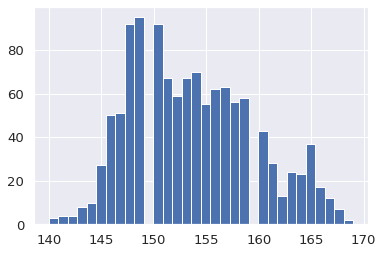

In [12]:
plt.hist(df['hr'], bins=32)

In [13]:
df.describe()

speed           hr        grade      cadence     distance
count  1199.000000  1199.000000  1199.000000  1199.000000  1199.000000
mean      4.070225   153.724771     0.019266   167.129274  2467.244037
std       0.568282     5.896660     3.302163     2.430153  1390.011156
min       1.300000   140.000000   -12.900000   158.000000     2.500000
25%       3.700000   149.000000    -1.400000   166.000000  1272.000000
50%       4.100000   153.000000     0.000000   166.000000  2479.000000
75%       4.400000   158.000000     1.400000   168.000000  3667.800000
max       6.300000   169.000000    14.500000   180.000000  4889.600000

In [14]:
df.corr()

speed        hr     grade   cadence  distance
speed     1.000000 -0.040884 -0.259672  0.384487 -0.097826
hr       -0.040884  1.000000 -0.043809 -0.246713  0.653308
grade    -0.259672 -0.043809  1.000000  0.066605  0.011962
cadence   0.384487 -0.246713  0.066605  1.000000 -0.436514
distance -0.097826  0.653308  0.011962 -0.436514  1.000000

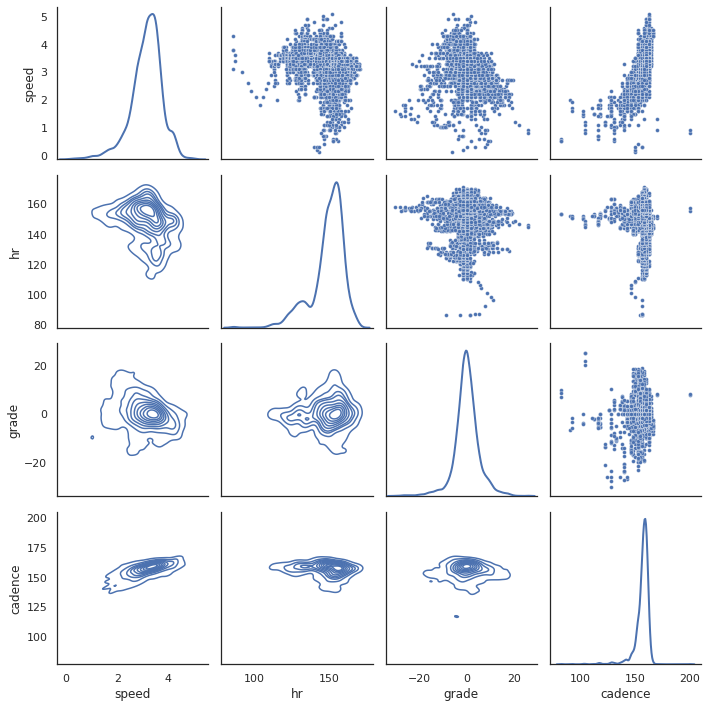

In [91]:
sns.set_theme(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

plt.tight_layout()
plt.savefig('activity.png')

In [59]:
from sklearn import linear_model
from sklearn import svm

In [64]:
classifiers = [
    svm.SVR(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

In [49]:
X = df.drop('speed', axis=1)
y = df['speed']

In [68]:
for item in classifiers:
    print(item, end= ' -> ')
    clf = item
    clf.fit(X, y)
    t = 1000 / clf.predict([[168, 0, 85]])[0]
    t_min = int(t/60)
    t_sec = int((t/60 - t_min)*60)
    print(f'{t_min}:{t_sec:02d}')

SVR(): 4:24
BayesianRidge(): 4:27
LassoLars(): 5:17
ARDRegression(): 4:13
PassiveAggressiveRegressor(): 5:10
TheilSenRegressor(max_subpopulation=10000): 4:09
LinearRegression(): 4:27


In [15]:
df['economy'] = 60 * df['speed'] / df['hr']

In [40]:
d_mva = df['economy'].rolling(window=60).mean()

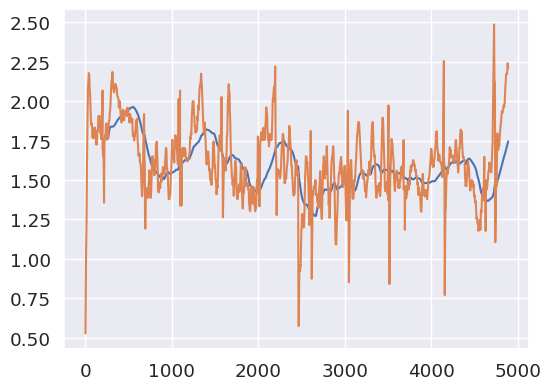

In [41]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
ax = fig.add_subplot()

plt.plot(d_mva)
plt.plot(df['economy'])
# plt.tight_layout()

<AxesSubplot:xlabel='distance'>

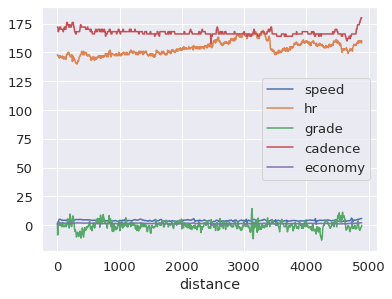

In [35]:
df.plot(figsize=(6,4.5))

In [34]:
df = df.set_index('distance')

array([[<AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'hr'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'cadence'}>],
       [<AxesSubplot:title={'center':'economy'}>, <AxesSubplot:>]],
      dtype=object)

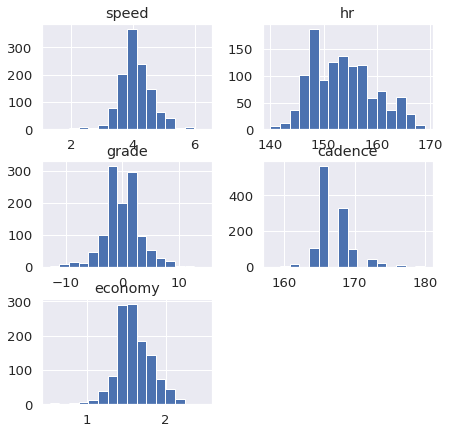

In [38]:
df.hist(figsize=(7,7), bins=16)

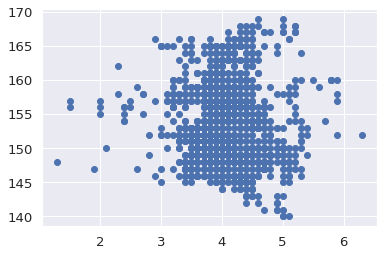

In [42]:
plt.scatter(df['speed'], df['hr'])